In [1]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from math import cos, sin, atan2, pi, sqrt
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import bisect


In [10]:
rng = np.random.RandomState(24)

# ========== CONSTANTS / PHYSICS ==========
W, H = 400, 200
MAX_SENSOR_RANGE = 80.0 # how far the sensors can see
SENSOR_ANGLES = [-0.35, 0.0, 0.35] # radians relative to car heading
DT = 1.0 # time step in seconds
MAX_SPEED = 320.0 # units per second
MAX_STEER_RATE = 0.20 
USE_CURVATURE=False
# Track parameters
cx, cy = W // 2, H // 2
outer_rx, outer_ry = 70, 90 # outer ellipse radii
inner_rx, inner_ry = 40, 60 # inner ellipse radii

# Network architecture
if USE_CURVATURE:
    INPUT_DIM = 6
else:
    INPUT_DIM = 5
HIDDEN = 8
OUTPUT_DIM = 3

# Genome size!!
NUM_WEIGHTS = INPUT_DIM * HIDDEN + HIDDEN + HIDDEN * OUTPUT_DIM + OUTPUT_DIM


# GA DEFAULTS
DEFAULT_POP_SIZE = 40 # drivers in each generation
DEFAULT_GENERATIONS = 100 # total number of generations to simulate
DEFAULT_TOURNAMENT = 6 # selected k for tournament selection
DEFAULT_CROSSOVER_RATE = 0.7 # probability of crossover between parents
DEFAULT_MUTATION_STD = 0.2 # range of mutation randomness
MUTATION_STEP = 0.1 # increase mutation step on stagnation
STAGNATION_LIMIT = 10 # increase mutation std when no new best occurs
MAX_MUTATION_STD = 1

In [3]:
# ========== TRACK CREATION ==========
def make_ring_track(W, H, cx, cy, outer_rx, outer_ry, inner_rx, inner_ry):
    """
    Create a ring-shaped track mask. The track is defined by an outer ellipse
    and an inner ellipse (the hole). The area between the two ellipses is the
    track where the car can drive (value 1), and the rest is off-track (value 0).
    0 = off-track, 1 = on-track
    """
    img = Image.new("L", (W, H), 0)
    draw = ImageDraw.Draw(img)
    bbox_outer = [cx - outer_rx, cy - outer_ry, cx + outer_rx, cy + outer_ry]
    draw.ellipse(bbox_outer, fill=1)
    bbox_inner = [cx - inner_rx, cy - inner_ry, cx + inner_rx, cy + inner_ry]
    draw.ellipse(bbox_inner, fill=0)
    mask = np.array(img, dtype=np.uint8)
    return mask

def generate_wiggly_ellipse(num_points=1000, width=20, wiggles=3, amp=0.2, W=400, H=200, semi_ax_x = 140, semi_ax_y=65):
    t = np.linspace(0, 2*np.pi, num_points, endpoint=False)
    a, b = semi_ax_x, semi_ax_y  # semi-axes
    
    # sinusoidal radial perturbation
    r = 1 + amp * np.sin(wiggles * t) 
    x = a * r * np.cos(t) + W/2
    y = b * r * np.sin(t) + H/2
    return np.stack([x, y], axis=1), width
    
def make_track_mask(track, width, W=400, H=200):
    mask = Image.new("L", (W, H), 0)
    draw = ImageDraw.Draw(mask)
    pts = [tuple(p) for p in track]
    draw.line(pts + [pts[0]], fill=1, width=width)
    return np.array(mask) > 0

def compute_geometry(track):
    diffs = np.diff(track, axis=0, append=track[:1])
    seg_lengths = np.linalg.norm(diffs, axis=1)
    s = np.cumsum(seg_lengths)
    s -= s[0]
    prev = np.roll(track, 1, axis=0)
    nxt = np.roll(track, -1, axis=0)
    a = np.linalg.norm(track - prev, axis=1)
    b = np.linalg.norm(track - nxt, axis=1)
    c = np.linalg.norm(nxt - prev, axis=1)
    area = 0.5 * np.abs(
        (prev[:,0]*(track[:,1]-nxt[:,1]) +
         track[:,0]*(nxt[:,1]-prev[:,1]) +
         nxt[:,0]*(prev[:,1]-track[:,1]))
    )
    kappa = 4 * area / (a * b * c + 1e-8)
    return s, kappa

def create_track(points=100000, wiggles=4, amp=0.3, width=20, W=400, H=200, semi_ax_x=140, semi_ax_y=65):
    plt.clf()
    
    track, track_width = generate_wiggly_ellipse(
        num_points=points, 
        width=width, 
        wiggles=wiggles, 
        amp=amp,
        W=W,
        H=H,
        semi_ax_x=semi_ax_x,
        semi_ax_y=semi_ax_y
    )
    track_mask = make_track_mask(track, track_width, W, H)
    s, kappa = compute_geometry(track)
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
    
    # plot track
    x = track[0,0]
    y = track[0,1]
    ax1.scatter(x, y, marker='s', color='g', s=50, label='Start')
    ax1.imshow(track_mask, cmap='gray', origin='upper', extent=[0, W, H, 0])
    ax1.plot(track[:,0], track[:,1], 'r--', linewidth=1, alpha=0.7)
    ax1.axis('equal')
    ax1.set_title(f'Wiggly Ellipse Grand Prix\nWiggles: {wiggles}, Amplitude: {amp:.2f}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks([])
    ax1.set_yticks([])
    # ax2.plot(s, kappa, 'b-', linewidth=2)
    # ax2.set_xlabel('Track Length')
    # ax2.set_ylabel('Curvature')
    # ax2.set_title('Track Curvature Profile')
    # ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("./track.png")

    plt.show()
    return track_mask, track, kappa, s

def create_fast_lookup(track, kappa, s, num_points=1000):
    """Create uniformly sampled lookup for O(1) access"""
    s_uniform = np.linspace(0, s[-1], num_points)
    # Find closest original points for each uniform sample
    kappa_uniform = np.zeros(num_points)
    for i, s_val in enumerate(s_uniform):
        idx = bisect.bisect_left(s, s_val) % len(s)
        kappa_uniform[i] = kappa[idx]
    
    return s_uniform, kappa_uniform

def create_fast_lookup(track, kappa, s, num_points=1000):
    """Create uniformly sampled lookup for O(1) access"""
    s_uniform = np.linspace(0, s[-1], num_points)
    # Find closest original points for each uniform sample
    kappa_uniform = np.zeros(num_points)
    for i, s_val in enumerate(s_uniform):
        idx = bisect.bisect_left(s, s_val) % len(s)
        kappa_uniform[i] = kappa[idx]
    
    return s_uniform, kappa_uniform

def verify_lookup_creation(track, kappa, s, s_lookup, kappa_lookup):
    """Verify the lookup table has meaningful curvature values"""
    print("=== Lookup Verification ===")
    print(f"Original kappa range: [{np.min(kappa):.4f}, {np.max(kappa):.4f}]")
    print(f"Lookup kappa range: [{np.min(kappa_lookup):.4f}, {np.max(kappa_lookup):.4f}]")
    print(f"Lookup points with |kappa| > 0.1: {np.sum(np.abs(kappa_lookup) > 0.1)}/{len(kappa_lookup)}")
    
    # Check some sample points
    sample_indices = [0, len(kappa_lookup)//4, len(kappa_lookup)//2, 3*len(kappa_lookup)//4]
    for idx in sample_indices:
        print(f"Lookup[{idx}]: s={s_lookup[idx]:.1f}, kappa={kappa_lookup[idx]:.4f}")
    
    # Plot to verify
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(s, kappa, 'b-', alpha=0.7, label='Original')
    plt.plot(s_lookup, kappa_lookup, 'ro', markersize=2, label='Lookup')
    plt.title('Curvature: Original vs Lookup')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(kappa_lookup, bins=50)
    plt.title('Lookup Curvature Distribution')
    plt.tight_layout()
    plt.show()

# use this for constant curvature 1/R (~ circular)
center_rx = (outer_rx + inner_rx) / 2.0
center_ry = (outer_ry + inner_ry) / 2.0
center_R = (center_rx + center_ry) / 2.0

In [4]:
def in_track(x, y, trck_msk):
    """
    This is a naive check, but works fine for our simple track.
    """
    xi = int(round(x))
    yi = int(round(y))
    if xi < 0 or yi < 0 or xi >= W or yi >= H:
        return False
    return trck_msk[yi, xi] == 1


def sensor_distances_fast(x, y, heading, trck_msk, step=4.0):
    """
    Calculate distances to track edges for each sensor angle.
    Uses a step size to incrementally check along the ray until hitting
    the edge of the track or going out of bounds.
    A higher step size is faster but less accurate.
    """
    dists = []
    maxsteps = int(MAX_SENSOR_RANGE / step) + 1
    for a in SENSOR_ANGLES:
        ray_ang = heading + a
        hit_dist = MAX_SENSOR_RANGE
        for i in range(maxsteps):
            dist = i * step
            sx = x + dist * cos(ray_ang)
            sy = y + dist * sin(ray_ang)
            if not (0 <= sx < W and 0 <= sy < H) or not in_track(sx, sy, trck_msk):
                hit_dist = dist
                break
        dists.append(min(hit_dist, MAX_SENSOR_RANGE))
    return np.array(dists, dtype=float) / MAX_SENSOR_RANGE


# ========== PROGRESS CALCULATION ==========
def progress_along_track(x, y):
    """
    This function calculates the angle of the point (x, y) relative to the
    center of the track (cx, cy). The angle is in radians and normalized to
    the range [0, 2*pi). This allows us to determine how far along the
    circular track the point is.

    We ll need a more complex function for more complex tracks.
    """
    ang = atan2(y - cy, x - cx)
    return ang if ang >= 0 else ang + 2 * pi


# TODO: check & verify this function
def calculate_net_progress(trace):
    """
    Calculate *cumulative* angular progress along the track given a trace of (x, y) points.
    Returns: (progress_percent, laps_completed, direction, total_distance)

    - Uses signed smallest-angle differences between consecutive points around track center
      to accumulate total angular change (so multiple laps and back-and-forth are counted).
    - direction: +1 for CCW, -1 for CW (based on sign of cumulative angle).
    """
    if not trace or len(trace) < 2:
        return 0.0, 0, 1, 0.0

    # total distance along path
    total_distance = 0.0
    for i in range(1, len(trace)):
        x1, y1 = trace[i - 1]
        x2, y2 = trace[i]
        total_distance += sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    # accumulate signed angular deltas about the track center
    def ang_at(p):
        return atan2(p[1] - cy, p[0] - cx)

    cum_angle = 0.0
    prev_ang = ang_at(trace[0])
    for i in range(1, len(trace)):
        a = ang_at(trace[i])
        # smallest signed delta in (-pi, pi]
        delta = (a - prev_ang + pi) % (2 * pi) - pi
        cum_angle += delta
        prev_ang = a

    # determine direction and laps
    direction = 1 if cum_angle >= 0 else -1
    abs_cum = abs(cum_angle)
    laps_completed = int(np.floor(abs_cum / (2 * pi)))
    progress_percent = (abs_cum % (2 * pi)) / (2 * pi) * 100.0

    # if more than full laps, add 100% for each full lap
    progress_percent += laps_completed * 100.0

    return progress_percent, laps_completed, direction, total_distance


# ========== NEURAL NETWORK ==========
def genome_to_network(genome):
    """ Convert a flat genome array into network weights and biases.
    """
    idx = 0
    w1 = genome[idx: idx + INPUT_DIM * HIDDEN].reshape((INPUT_DIM, HIDDEN))
    idx += INPUT_DIM * HIDDEN
    b1 = genome[idx: idx + HIDDEN]
    idx += HIDDEN
    w2 = genome[idx: idx + HIDDEN * OUTPUT_DIM].reshape((HIDDEN, OUTPUT_DIM))
    idx += HIDDEN * OUTPUT_DIM
    b2 = genome[idx: idx + OUTPUT_DIM]
    idx += OUTPUT_DIM
    return w1, b1, w2, b2


def forward_network(genome, inputs):
    w1, b1, w2, b2 = genome_to_network(genome)
    # forward pass
    h = np.tanh(np.dot(inputs, w1) + b1)
    out = np.dot(h, w2) + b2

    # output layer activation
    steer = np.tanh(out[0]) *  0.8 # tanh -1 to 1 scaled to -0.8 to 0.8
    accel = 1.0 / (1.0 + np.exp(-out[1]))  # sigmoid 0-1
    brake = 1.0 / (1.0 + np.exp(-out[2]))  # sigmoid 0-1

    # if accel > 0.7 and brake > 0.7:
    #     brake = 0.3

    return steer, accel, brake


def find_nearest_track_point(x, y, track):
    """Find the index of the nearest track point to current position"""
    distances = np.linalg.norm(track - np.array([x, y]), axis=1)
    return np.argmin(distances)

def get_future_curvature(current_idx, track_length, kappa, lookahead_distance=20):
    """Get average curvature looking ahead along the track"""
    points_ahead = int(lookahead_distance) 
    
    future_idx = (current_idx + points_ahead) % len(kappa)
    return kappa[future_idx]


def get_curvature_lookup(x, y, prev_idx, s_lookup, kappa_lookup, conversion_factor, speed=0.0):
    """O(1) curvature lookup using car's progress"""
    search_radius = max(200,int(110*speed))
    N = len(s_lookup)
    k_factor = 0.3

    start = max(0, prev_idx - search_radius)
    end   = min(N, prev_idx + search_radius)
    local_track = track[start:end]
    local_idx = np.argmin((local_track[:, 0] - x)**2 + (local_track[:, 1] - y)**2)
    current_lookup_idx = (start + local_idx) % N
    # Estimate current arc length based on previous index + movement
    # current_lookup_idx = (prev_idx + 1) % len(s_lookup)
    k_factor =0.3
    if USE_ADAPTIVE_CURVATURE_LOOKUP:
        lookahead_idx = int(current_lookup_idx + int(speed * DT*k_factor)) % len(s_lookup)
    else:
        lookahead_idx = (current_lookup_idx + 10) % len(s_lookup)
    
    kappa_max = np.max(np.abs(kappa_lookup)) if np.any(kappa_lookup) else 1.0
    return float(kappa_lookup[lookahead_idx]) / (kappa_max + 1e-8), current_lookup_idx

# ========== SIMULATION ==========
def simulate_one(genome, trck_msk, track, kappa, s, max_steps=1000, sensor_step=4.0, 
                 return_trace=False, return_controls=False):
    """
    Simulate one car controlled by the given genome, from start until max_steps
    or crash.
    Returns final position, trace, crash status, and controls data.
    """
    cx, cy = track.mean(axis=0)
    # start near the first point
    x, y = track[0]
    heading = atan2(track[1,1] - track[0,1], track[1,0] - track[0,0])
    speed = 0.0
    trace = [(x, y)]
    controls_data = []

    # deprecated---------------
    current_track_idx = 0 
    total_track_length = s[-1]  
    #--------------------------
    
    # race!
    current_lookup_idx = 0

    for step in range(max_steps):
        sensor = sensor_distances_fast(x, y, heading, trck_msk, step=sensor_step)
        
        speed_norm = speed / MAX_SPEED
        
        # UPDATE: Use actual curvature from track geometry
        # next_turn_curvature =1.0 / max(1.0, center_R)
        # current_track_idx = find_nearest_track_point(x, y, track)
        # next_turn_curvature = get_future_curvature(current_track_idx, s, kappa, lookahead_distance=MAX_SENSOR_RANGE)
        
        next_turn_curvature, current_lookup_idx = get_curvature_lookup(
        x, y, current_lookup_idx, s_lookup, kappa_lookup, conversion_factor, speed=speed)

        next_idx = (current_lookup_idx + 1) % len(track)
        tangent = -atan2(track[next_idx,1] - track[current_lookup_idx,1],
                         track[next_idx,0] - track[current_lookup_idx,0])
        # tangent = -atan2(track[current_lookup_idx+1,1] - track[current_lookup_idx,1],
        #         track[current_lookup_idx+1,0] - track[current_lookup_idx,0])
        rel_angle = ((heading - tangent) + pi) % (2 * pi) - pi

        # tangent = atan2(y - cy, x - cx) + pi / 2
        if USE_CURVATURE:
            inputs = np.array(
                [sensor[0], sensor[1], sensor[2], speed_norm, rel_angle / pi,
                 next_turn_curvature], dtype=float)
        else:
            inputs = np.array(
                [sensor[0], sensor[1], sensor[2], speed_norm, rel_angle / pi], dtype=float)
        steer, accel, brake = forward_network(genome, inputs)

        if return_controls:
            controls_data.append(
                {'step': step, 
                 'steer': steer,
                 'accel': accel, 
                 'brake': brake,
                'speed': speed,
                'sensor_left': sensor[0],
                'sensor_center': sensor[1],
                'sensor_right': sensor[2],
                'curvature': next_turn_curvature, 
                'track_idx': current_lookup_idx  
                 })

        # physics (unchanged)
        steer_rate = steer * MAX_STEER_RATE
        accel_force = accel * 2.2
        brake_force = brake * 2.8
        
        heading += steer_rate * DT
        speed += (accel_force - brake_force) * DT
        speed = max(0.0, min(MAX_SPEED, speed))
        speed *= 0.98

        # update position
        prev_x, prev_y = x, y
        x += speed * cos(heading) * DT
        y += speed * sin(heading) * DT

        if return_trace:
            trace.append((x, y))

        # crash check
        if not (0 <= x < W and 0 <= y < H) or not in_track(x, y, trck_msk):
            return None, (
                trace if return_trace else None), True, None, controls_data

    return None, (trace if return_trace else None), False, None, controls_data


# ========== FITNESS FUNCTION ==========
def evaluate_pop_fitness(pop, trck_msk):
    """
    Evaluate fitness of the entire population. Returns fitness array and progress data for monitoring.
    1. simulate each individual
    2. calculate progress, direction, distance
    3. compute fitness with penalties and bonuses
    4. return fitness array and progress data
    """
    fits = np.zeros(len(pop), dtype=float)
    progress_data = []  

    for i, ind in enumerate(pop):
        _, trace, crashed, _, _ = simulate_one(ind,trck_msk,track, kappa, s, max_steps=1000,
                                               return_trace=True)

        if not trace or len(trace) < 10:
            fits[i] = 0.1
            progress_data.append((0.0, 0, 1, 0.0, True))
            continue

        progress_percent, laps_completed, direction, total_distance = calculate_net_progress(
            trace)

        progress_data.append(
            (progress_percent, laps_completed, direction, total_distance, crashed))

        # simple fitness: progress percentage
        fitness = progress_percent * 100 

        # penalties for going backwards and crashing
        if direction < 0:  # backwards
            fitness *= 0.1  # 90% penalty
        if crashed:
            fitness *= 0.5  # 50% penalty 

        # efficiency bonus for progress with less distance
        if progress_percent > 10 and total_distance > 0:
            efficiency = progress_percent / (total_distance / 100)
            fitness += min(50, efficiency * 5)

        fits[i] = max(1.0, fitness)

    return fits, progress_data


# ========== GENETIC ALGORITHM ==========
def create_population(pop_size=DEFAULT_POP_SIZE):
    return rng.normal(scale=0.3, size=(pop_size, NUM_WEIGHTS)).astype(
        np.float32)


def tournament_select(pop, fits, k=DEFAULT_TOURNAMENT):
    """
    tournament selection: pick k random individuals and return the best one.
    1. randomly select k indices from the population
    2. find the index of the best fitness among them
    3. return a copy of the best individual
    4. ensures diversity and selection pressure

    best inddividual in the current population is not guaranteed to be selected
    """
    idxs = rng.choice(len(pop), size=k, replace=False)
    best = idxs[np.argmax(fits[idxs])]
    return pop[best].copy()


def crossover(p1, p2, rate=DEFAULT_CROSSOVER_RATE):
    """
    uniform crossover: for each gene, randomly choose from one of the parents.

    """
    if rng.rand() > rate:
        return p1.copy(), p2.copy()
    alpha = rng.rand(NUM_WEIGHTS)
    return alpha * p1 + (1 - alpha) * p2, (1 - alpha) * p1 + alpha * p2


def mutate(g, sigma=DEFAULT_MUTATION_STD):
    return g + rng.normal(scale=sigma, size=g.shape)


In [5]:
# ========== PLOT FUNCTIONS ==========
def plot_controls(controls_data, title="Control Inputs Over Time"):
    if not controls_data:
        print("No control data to plot")
        return
        
    steps = [c['step'] for c in controls_data]
    steer = [c['steer'] for c in controls_data]
    accel = [c['accel'] for c in controls_data]
    brake = [c['brake'] for c in controls_data]
    speed = [c['speed'] for c in controls_data]
    curvature =[c['curvature'] for c in controls_data]
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    
    ax1.plot(steps, steer, 'b-', linewidth=2)
    if USE_CURVATURE:
        ax1.plot(steps, curvature, 'r', linewidth=2) 
    ax1.set_ylabel('Steering (-1 to 1)')
    ax1.set_ylim(-1.1, 1.1)
    ax1.grid(True)
    ax1.set_title('Steering Input')
    
    ax2.plot(steps, accel, 'g-', label='Throttle', linewidth=2)
    ax2.plot(steps, brake, 'r-', label='Brake', linewidth=2)
    ax2.set_ylabel('Throttle/Brake (0 to 1)')
    ax2.set_ylim(-0.1, 1.1)
    ax2.legend()
    ax2.grid(True)
    ax2.set_title('Throttle and Brake')
    
    ax3.plot(steps, speed, 'purple', linewidth=2)
    ax3.set_ylabel('Speed')
    ax3.set_xlabel('Simulation Step')
    ax3.grid(True)
    ax3.set_title('Speed Over Time')
    
    sensor_left = [c['sensor_left'] for c in controls_data]
    sensor_center = [c['sensor_center'] for c in controls_data] 
    sensor_right = [c['sensor_right'] for c in controls_data]
    
    ax4.plot(steps, sensor_left, 'orange', label='Left Sensor', alpha=0.7)
    ax4.plot(steps, sensor_center, 'brown', label='Center Sensor', alpha=0.7)
    ax4.plot(steps, sensor_right, 'pink', label='Right Sensor', alpha=0.7)
    ax4.set_ylabel('Sensor Distance (0-1)')
    ax4.set_xlabel('Simulation Step')
    ax4.legend()
    ax4.grid(True)
    ax4.set_title('Sensor Readings')
    
    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()


def plot_historical_trajectories(historical_bests, track_mask, max_display=5):
    """Plot trajectories from different generations to show improvement over time"""
    if not historical_bests:
        print("No historical data to plot")
        return
    
    # select a subset of generations to display (evenly spaced + final)
    n_bests = len(historical_bests)
    if n_bests <= max_display:
        selected_indices = list(range(n_bests))
    else:
        # select evenly spaced indices including first and last
        step = n_bests // (max_display - 1)
        selected_indices = [0] + [i * step for i in range(1, max_display - 1)] + [n_bests - 1]
        selected_indices = [-3, -2,  -1]
    
    plt.figure(figsize=(12, 8))
    plt.imshow(track_mask, origin='lower', alpha=0.7, cmap='gray')
    
    # cmap for different generations
    import matplotlib.cm as cm
    colors = cm.get_cmap('plasma')(np.linspace(0, 1, len(selected_indices)))
    
    for i, idx in enumerate(selected_indices):
        best = historical_bests[idx]
        if best['trace']:
            tx = [p[0] for p in best['trace']]
            ty = [p[1] for p in best['trace']]
            
            plt.plot(tx, ty, color=colors[i], linewidth=2, alpha=0.8,
                    label=f"Gen {best['generation']}: {best['fitness']:.0f} fitness")

            # start and end points
            plt.scatter(tx[0], ty[0], color=colors[i], marker='o', s=50, edgecolor='white')
            plt.scatter(tx[-1], ty[-1], color=colors[i], marker='s', s=50, edgecolor='white')
    
    plt.title('Mejoras históricas en trayectorias')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("./historical_trajectories.png")
    plt.show()


def plot_historical_speed_comparison(historical_bests, max_display=3):
    """Compare speed profiles across different generations"""
    if not historical_bests:
        print("No historical data to plot")
        return

    # compare up to three generations
    n_bests = len(historical_bests)
    if n_bests == 1:
        selected_indices = [0]
    elif n_bests == 2:
        selected_indices = [0, 1]
    else:
        selected_indices = [-3, -2,  -1]
    
    plt.figure(figsize=(15, 5))
    
    for i, idx in enumerate(selected_indices):
        best = historical_bests[idx]
        if best['controls']:
            plt.subplot(1, len(selected_indices), i + 1)
            
            steps = [c['step'] for c in best['controls']]
            speeds = [c['speed'] for c in best['controls']]
            
            plt.plot(steps, speeds, 'b-', linewidth=2)
            plt.title(f"Gen {best['generation']}\nFitness: {best['fitness']:.0f}")
            plt.xlabel('Simulation Step')
            plt.ylabel('Speed')
            plt.grid(True)
            plt.ylim(0, MAX_SPEED)
    
    plt.suptitle('Speed Evolution Across Generations', fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_historical_controls_comparison(historical_bests, max_display=3):
    """Compare control inputs across different generations"""
    if not historical_bests:
        print("No historical data to plot")
        return
    
    n_bests = len(historical_bests)
    if n_bests == 1:
        selected_indices = [0]
    elif n_bests == 2:
        selected_indices = [0, 1]
    else:
        selected_indices = [-3, -2,  -1]
    
    fig, axes = plt.subplots(2, len(selected_indices), figsize=(15, 10))
    if len(selected_indices) == 1:
        axes = axes.reshape(-1, 1)
    
    for i, idx in enumerate(selected_indices):
        best = historical_bests[idx]
        if best['controls']:
            steps = [c['step'] for c in best['controls']]
            steer = [c['steer'] for c in best['controls']]
            accel = [c['accel'] for c in best['controls']]
            brake = [c['brake'] for c in best['controls']]
            
            # steering
            # axes[0, i].plot(steps, steer, 'b-', linewidth=2)
            # axes[0, i].set_title(f"Gen {best['generation']} - Steering")
            # axes[0, i].set_ylabel('Steering')
            # axes[0, i].set_ylim(-1, 1)
            # axes[0, i].grid(True)
            
            # throttle and brake
            axes[0, i].plot(steps, accel, 'g-', label='Throttle', linewidth=2)
            axes[0, i].plot(steps, brake, 'r-', label='Brake', linewidth=2)
            axes[0, i].set_title(f"Gen {best['generation']} - Throttle/Brake")
            axes[0, i].set_ylabel('Input')
            axes[0, i].set_ylim(0, 1)
            axes[0, i].legend()
            axes[0, i].grid(True)
            
            # speed
            speeds = [c['speed'] for c in best['controls']]
            axes[1, i].plot(steps, speeds, 'purple', linewidth=2)
            axes[1, i].set_title(f"Gen {best['generation']} - Speed")
            axes[1, i].set_xlabel('Simulation Step')
            axes[1, i].set_ylabel('Speed')
            axes[1, i].grid(True)
    
    plt.suptitle('Control Evolution Across Generations', fontsize=14)
    plt.tight_layout()
    plt.savefig("./historical_controls.png")
    plt.show()

import matplotlib.pyplot as plt

def plot_improvement_timeline(historical_bests):
    if not historical_bests:
        return

    generations = [b['generation'] for b in historical_bests]
    fitnesses   = [b['fitness'] for b in historical_bests]
    progresses  = [b['progress'] for b in historical_bests]

    plt.figure(figsize=(10, 5))
    plt.plot(generations, fitnesses, '-o', color='tab:blue', linewidth=2, markersize=5)
    plt.xlabel('Generación')
    plt.ylabel('Fitness')
    plt.title('Evolución del Fitness del Mejor Individuo')
    plt.grid(True, linestyle='--', alpha=0.6)

    for i, (gen, fit) in enumerate(zip(generations, fitnesses)):
        if i == 0 or i == len(fitnesses) - 1 or fit - fitnesses[i-1] > 500:
            dy = 20 if (i == 0 or fit < fitnesses[i-1]) else -20
            plt.annotate(f'{fit:.0f}', xy=(gen, fit),
                         xytext=(0, dy), textcoords='offset points',
                         ha='center', va='bottom' if dy > 0 else 'top',
                         fontsize=8, color='tab:blue', alpha=0.85,
                         arrowprops=dict(arrowstyle='-', lw=0.5, alpha=0.4))

    plt.tight_layout()
    plt.savefig("./convergencia_fitness.png", dpi=150)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(generations, progresses, '-o', color='tab:green', linewidth=2, markersize=5)
    plt.xlabel('Generación')
    plt.ylabel('Progreso en la pista (%)')
    plt.title('Progreso sobre la pista a lo largo de las generaciones')
    plt.grid(True, linestyle='--', alpha=0.6)

    for i, (gen, prog) in enumerate(zip(generations, progresses)):
        if i == 0 or i == len(progresses) - 1 or prog - progresses[i-1] > 5:
            dy = 10 if (i == 0 or prog < progresses[i-1]) else -10
            plt.annotate(f'{prog:.0f}%', xy=(gen, prog),
                         xytext=(0, dy), textcoords='offset points',
                         ha='center', va='bottom' if dy > 0 else 'top',
                         fontsize=8, color='tab:green', alpha=0.85,
                         arrowprops=dict(arrowstyle='-', lw=0.5, alpha=0.4))

    plt.tight_layout()
    plt.savefig("./convergencia_progreso.png", dpi=150)
    plt.show()



def visualize_curvature_lookup(track, kappa, s, s_lookup, kappa_lookup, 
                             current_s, lookahead_distance, current_pos=None):
    """
    Visualize the curvature lookup system
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1.plot(track[:, 0], track[:, 1], 'b-', alpha=0.7, linewidth=1, label='Track')
    ax1.set_aspect('equal')
    ax1.set_title('Track with Lookahead Position')
    ax1.grid(True, alpha=0.3)
    
    if current_pos is not None:
        ax1.plot(current_pos[0], current_pos[1], 'go', markersize=8, label='Current Position')
        
        target_s = (current_s + lookahead_distance) % s[-1]
        lookahead_idx = np.argmin(np.abs(s - target_s))
        lookahead_pos = track[lookahead_idx]
        
        ax1.plot(lookahead_pos[0], lookahead_pos[1], 'ro', markersize=8, label='Lookahead Position')
        ax1.legend()
    
    ax2.plot(s, kappa, 'b-', alpha=0.7, linewidth=2, label='Original Curvature')
    ax2.plot(s_lookup, kappa_lookup, 'r--', alpha=0.8, linewidth=1, label='Lookup Points')
    
    if current_s is not None:
        current_kappa = np.interp(current_s, s, kappa)
        ax2.axvline(x=current_s, color='green', linestyle='-', alpha=0.8, label='Current s')
        ax2.plot(current_s, current_kappa, 'go', markersize=8)
        
        target_s = (current_s + lookahead_distance) % s[-1]
        lookahead_kappa = np.interp(target_s, s, kappa)
        ax2.axvline(x=target_s, color='red', linestyle='-', alpha=0.8, label='Lookahead s')
        ax2.plot(target_s, lookahead_kappa, 'ro', markersize=8)
        
        lookup_idx = int(target_s * (len(s_lookup) / s[-1])) % len(s_lookup)
        used_kappa = kappa_lookup[lookup_idx]
        ax2.plot(target_s, used_kappa, 'rx', markersize=12, markeredgewidth=2, label='Used Curvature')
    
    ax2.set_xlabel('Track Length (s)')
    ax2.set_ylabel('Curvature (kappa)')
    ax2.set_title('Curvature Profile with Lookahead')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    if current_s is not None:
        print(f"Current s: {current_s:.1f}")
        print(f"Lookahead s: {target_s:.1f}")
        print(f"Actual curvature at lookahead: {lookahead_kappa:.4f}")
        print(f"Lookup curvature used: {used_kappa:.4f}")
        print(f"Error: {abs(lookahead_kappa - used_kappa):.4f}")
    

In [6]:
def plot_results(results):
    plt.figure(figsize=(8, 4))
    plt.plot(results["best_history"], label='Mejor', linewidth=2, color='tab:blue')
    plt.plot(results["mean_history"], label='Media', linewidth=2, color='tab:orange', alpha=0.8)
    plt.xlabel('Generación')
    plt.ylabel('Fitness')
    plt.title('Evolución del Fitness')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig("./learning_curve.png", dpi=150)
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.imshow(track_mask, origin='lower', cmap='gray')
    plt.title('Trayectoria del Mejor Individuo')
    plt.axis('off')

    if results["historical_bests"]:
        tx = [p[0] for p in results["historical_bests"][-1]["trace"]]
        ty = [p[1] for p in results["historical_bests"][-1]["trace"]]
        speeds = [c['speed'] for c in results["historical_bests"][-1]["controls"]]

        min_len = min(len(tx), len(speeds))
        tx_plot, ty_plot, speeds_plot = tx[:min_len], ty[:min_len], speeds[:min_len]

        scatter = plt.scatter(tx_plot, ty_plot, c=speeds_plot, cmap='viridis',
                              s=12, alpha=0.85)
        cbar = plt.colorbar(scatter, shrink=0.3, pad=0.02)
        cbar.set_label('Velocidad', rotation=270, labelpad=15)
        plt.plot(tx, ty, color='black', alpha=0.3, linewidth=1)

    plt.tight_layout()
    plt.savefig("./best_trace.png", dpi=150)
    plt.show()
    
    # ========== HISTORICAL ANALYSIS ==========
    historical_bests =  results["historical_bests"]
    if historical_bests:
        print(f"\nFound {len(historical_bests)} improvements during evolution:")
        for i, best in enumerate(historical_bests):
            print(f"  {i+1}. Gen {best['generation']}: {best['fitness']:.0f} fitness, {best['progress']:.1f}% progress")
        
        plot_improvement_timeline(historical_bests)
        
        plot_historical_trajectories(historical_bests, track_mask, max_display=5)
        
        plot_historical_speed_comparison(historical_bests, max_display=3)
        
        plot_historical_controls_comparison(historical_bests, max_display=3)
    best_controls_overall = results["historical_bests"][-1]["controls"]
    if best_controls_overall:
        plot_controls(best_controls_overall, title="Final Best Driver Control Inputs Over Time")

In [7]:
# ========== MAIN EVOLUTION ==========
def run_simulation(pop_size=DEFAULT_POP_SIZE, mutation_std=DEFAULT_MUTATION_STD, 
                   crossover_rate=DEFAULT_CROSSOVER_RATE,
                   generations=DEFAULT_GENERATIONS, tournament=DEFAULT_TOURNAMENT):
    population = create_population(pop_size)
    best_history, mean_history = [], []
    best_trace_overall = None
    best_controls_overall = None
    best_fitness_overall = -1.0
    best_genome_overall = None
    stagnation_counter = 0
    current_mutation_std = mutation_std
    
    historical_bests = []  # List of (generation, fitness, genome, trace, controls)
    
    print("Starting evolution...")
    print("Gen | Best Fitness |  Progress% |  Laps | Dir | Distance | Status | MutRate")
    print("----|--------------|------------|-------|-----|----------|--------|--------")
    
    for gen in range(generations):
        fits, progress_data = evaluate_pop_fitness(population, track_mask)
        mean_history.append(float(np.mean(fits)))
        best_idx = int(np.argmax(fits))
        best_val = float(fits[best_idx])
        best_history.append(best_val)
    
        # best individual progress info
        best_progress, best_laps, best_direction, best_distance, best_crashed = progress_data[
            best_idx]
        direction_symbol = "→" if best_direction > 0 else "←"
        status = "CRASH" if best_crashed else "OK"
    
        # Check if new best
        is_new_best = best_val > best_fitness_overall
        if is_new_best:
            best_fitness_overall = best_val
            best_genome_overall = population[best_idx].copy()
            _, best_trace_overall, _, _, best_controls_overall = simulate_one(best_genome_overall, track_mask,
                                                                               track, kappa, s,
                                                          max_steps=1000,
                                                          return_trace=True, return_controls=True)
            
            historical_bests.append({
                'generation': gen + 1,
                'fitness': best_val,
                'genome': best_genome_overall.copy(),
                'trace': best_trace_overall.copy() if best_trace_overall else None,
                'controls': best_controls_overall.copy() if best_controls_overall else None,
                'progress': best_progress,
                'laps': best_laps,
                'direction': best_direction,
                'distance': best_distance
            })
            
            new_best_marker = "NEW BEST!"
            stagnation_counter = 0
            current_mutation_std = mutation_std
        else:
            stagnation_counter += 1
            new_best_marker = ""
    
        # adaptive mutation adjustment
        if stagnation_counter > 0 and stagnation_counter % STAGNATION_LIMIT == 0:
            current_mutation_std = min(MAX_MUTATION_STD, current_mutation_std + MUTATION_STEP)
            print(f" Stagnation detected ({stagnation_counter} gens) → Mutation std increased to {current_mutation_std:.2f}")
    
        print(
            f"{gen + 1:3d} | {best_val:12.0f} | {best_progress:9.1f}% | {best_laps:5d} |  {direction_symbol}  | {best_distance:9.0f} | {status:5} | {current_mutation_std:.2f} {new_best_marker}"
        )
    
        new_pop = []
    
        #  best individual
        elite_idx = np.argsort(fits)[-1:]
        new_pop.append(population[elite_idx[0]].copy())
        # add random individuals
        for _ in range(3):
            new_pop.append(create_population(1)[0])
    
        # fill rest with selection/crossover/mutation
        while len(new_pop) < pop_size:
            p1 = tournament_select(population, fits, k=tournament)
            p2 = tournament_select(population, fits, k=tournament)
            c1, c2 = crossover(p1, p2)
            c1 = mutate(c1, current_mutation_std)
            c2 = mutate(c2, current_mutation_std)
            new_pop.append(c1)
            if len(new_pop) < pop_size:
                new_pop.append(c2)
    
        population = np.vstack(new_pop)[:pop_size]
    
    # ========== RESULTS ==========
    print(f"\nEvolution completed! Final best: {best_fitness_overall:.0f} fitness")
    
    if best_trace_overall:
        progress_percent, laps_completed, direction, total_distance = calculate_net_progress(
            best_trace_overall)
        direction_text = "Counter-Clockwise" if direction > 0 else "Clockwise"
        print(
            f"Best driver: {progress_percent:.1f}% progress, {direction_text}, {total_distance:.0f} units")
    results = {
        "best_history":best_history,
        "mean_history":mean_history,
        "historical_bests": historical_bests
    }
    return results

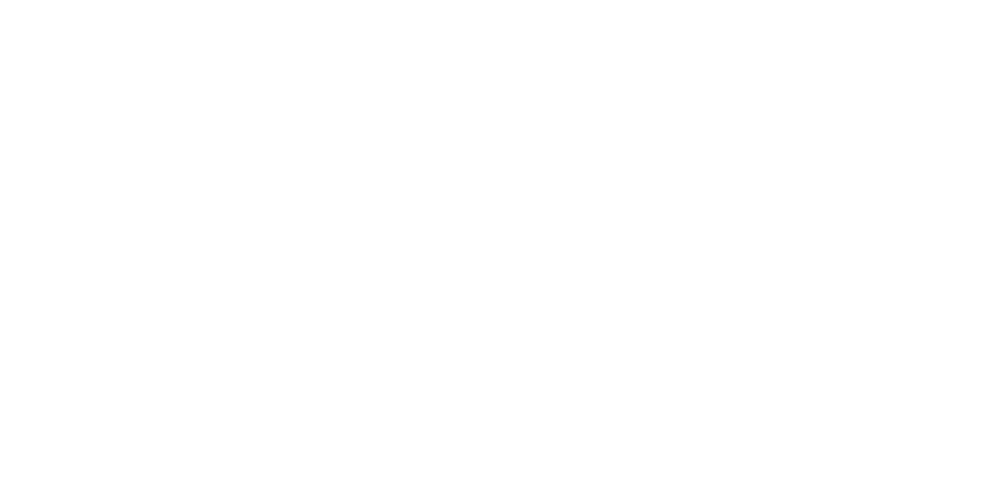

=== Lookup Verification ===
Original kappa range: [0.0000, 0.2186]
Lookup kappa range: [0.0000, 0.2185]
Lookup points with |kappa| > 0.1: 31/1000
Lookup[0]: s=0.0, kappa=0.0067
Lookup[250]: s=185.5, kappa=0.0019
Lookup[500]: s=371.0, kappa=0.0069
Lookup[750]: s=556.5, kappa=0.0020


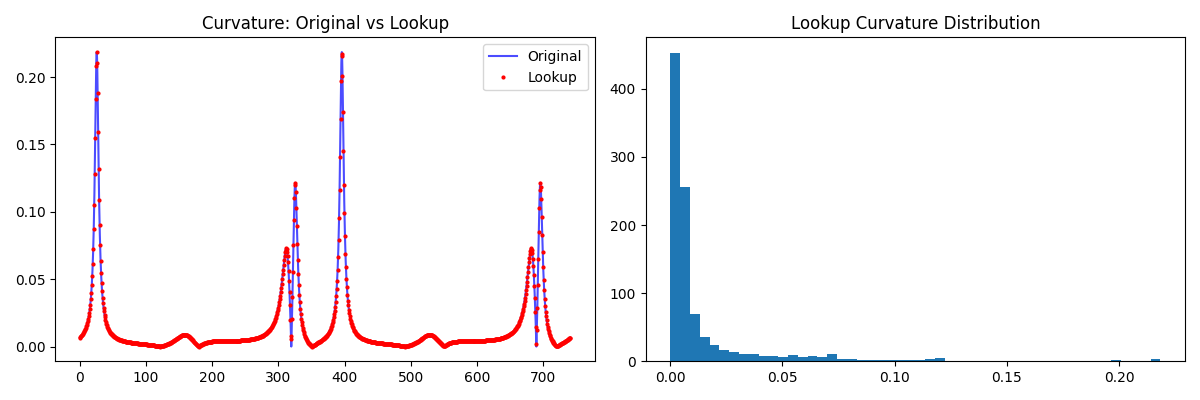

In [8]:
# ========== CREATE A TRACK ==========
LOOKUP_TABLE_POINTS = 1000
track_mask, track,  kappa,s = create_track(points=100000, wiggles=4, amp=0.2, width=20, W=400, H=200, semi_ax_x=150, semi_ax_y=40)

s_lookup, kappa_lookup = create_fast_lookup(track, kappa, s, LOOKUP_TABLE_POINTS)
conversion_factor = LOOKUP_TABLE_POINTS / s[-1]  # points per meter
verify_lookup_creation(track, kappa, s, s_lookup, kappa_lookup)

In [ ]:
USE_ADAPTIVE_CURVATURE_LOOKUP = False # see curvature ahead, based on current velocity
# GA parameters
POP_SIZE = 100 # drivers in each generation
GENERATIONS = 300 # total number of generations to simulate
TOURNAMENT = 4 # selected k for tournament selection
CROSSOVER_RATE = 0.7 # probability of crossover between parents
MUTATION_STD = 0.2 # range of mutation randomness
MUTATION_STEP = 0.1 # increase mutation step on stagnation
STAGNATION_LIMIT = 10 # increase mutation std when no new best occurs
MAX_MUTATION_STD = 0.8

results = run_simulation(pop_size=POP_SIZE, mutation_std=MUTATION_STD, crossover_rate=CROSSOVER_RATE,generations=GENERATIONS, tournament=TOURNAMENT)

Starting evolution...
Gen | Best Fitness |  Progress% |  Laps | Dir | Distance | Status | MutRate
----|--------------|------------|-------|-----|----------|--------|--------
  1 |          183 |       3.7% |     0 |  →  |        40 | CRASH | 0.20 NEW BEST!
  2 |         1790 |      34.8% |     0 |  →  |       211 | CRASH | 0.20 NEW BEST!


In [ ]:
%matplotlib inline
plot_results(results)